In [10]:
# Imports and plotting style
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib.ticker import MaxNLocator

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({"figure.dpi": 120, "axes.spines.top": False, "axes.spines.right": False})
rng = np.random.default_rng(42)

In [11]:
# File locations and group definitions
DATA_DIR = Path('Data')
MAT_FILES = [
    'FB (Amit - OpenField_4ch)_new.mat',
    'FG (Amit - OpenField_4ch)_new.mat',
    'FR (Amit - OpenField_4ch)_new.mat',
    'FW (Amit - OpenField_4ch)_new.mat',
    'MB (Amit - OpenField_4ch)_new.mat',
    'MG (Amit - OpenField_4ch)_new.mat',
    'MR (Amit - OpenField_4ch)_new.mat',
    'MW (Amit - OpenField_4ch)_new.mat',
]

SEX_GROUPS = {
    'Females': ['FB', 'FG', 'FR', 'FW'],
    'Males': ['MB', 'MG', 'MR', 'MW'],
}
ANIMAL_SEX = {animal: sex for sex, animals in SEX_GROUPS.items() for animal in animals}

BEHAVIORS = {
    'durational': ['Freezing_start_stop', 'grooming_start_stop'],
    'event': ['crossing_times', 'periphery_times'],
}

TOTAL_DURATION = 600  # seconds
BIN_COUNT = 4
BIN_EDGES = np.linspace(0, TOTAL_DURATION, BIN_COUNT + 1)
BINS = list(zip(BIN_EDGES[:-1], BIN_EDGES[1:]))
BIN_LABELS = [f'Bin {i+1}\n({int(start)}-{int(end)}s)' for i, (start, end) in enumerate(BINS)]

In [12]:
def load_open_field(mat_files, data_dir=DATA_DIR):
    """Load MATLAB files into a dict keyed by animal code."""
    loaded = {}
    for file in mat_files:
        file_path = data_dir / file
        animal = file.split()[0]
        if not file_path.exists():
            raise FileNotFoundError(f'Missing file: {file_path}')
        loaded[animal] = sio.loadmat(file_path)
    return loaded

def get_bin_events(events, bin_start, bin_end, total_duration=TOTAL_DURATION):
    """Return events within a bin; supports timestamp arrays or start/stop matrices."""
    arr = np.asarray(events)
    if arr.size == 0:
        return np.array([])

    max_time = float(arr.max())
    offset = max(max_time - total_duration, 0)
    adj = arr - offset

    if adj.ndim == 2 and adj.shape[0] == 2:
        starts, stops = adj
        mask = (starts < bin_end) & (stops > bin_start)
        if not mask.any():
            return np.array([[], []])
        clipped_starts = np.maximum(starts[mask], bin_start)
        clipped_stops = np.minimum(stops[mask], bin_end)
        return np.vstack([clipped_starts, clipped_stops])

    flat = adj.ravel()
    mask = (flat >= bin_start) & (flat <= bin_end)
    return flat[mask]

def bin_behavior_data(raw_data, bins=BINS, behaviors=BEHAVIORS):
    """Bin events for each animal and compute per-bin summaries."""
    binned = {}
    records = []

    for animal, payload in raw_data.items():
        if str(animal).startswith('__'):
            continue
        binned[animal] = {}
        animal_sex = ANIMAL_SEX.get(animal, 'Unknown')

        for bin_idx, (bin_start, bin_end) in enumerate(bins, start=1):
            bin_key = f'Bin_{bin_idx}'
            binned[animal][bin_key] = {}

            # Durational behaviors (start/stop)
            durations = {}
            for behavior in behaviors['durational']:
                events = payload.get(behavior, np.array([]))
                filtered = get_bin_events(events, bin_start, bin_end)
                duration = float(np.sum(filtered[1] - filtered[0])) if filtered.size and filtered.shape[0] == 2 else 0.0
                durations[behavior] = duration
                binned[animal][bin_key][behavior] = filtered

            # Event counts
            counts = {}
            for behavior in behaviors['event']:
                events = payload.get(behavior, np.array([]))
                filtered = get_bin_events(events, bin_start, bin_end)
                count = int(filtered.size) if filtered.size else 0
                counts[behavior] = count
                binned[animal][bin_key][behavior] = filtered

            center_count = max(counts.get('crossing_times', 0) - counts.get('periphery_times', 0), 0)
            binned[animal][bin_key]['center_count'] = center_count

            records.append({
                'animal': animal,
                'sex': animal_sex,
                'bin': bin_key,
                'crossings': counts.get('crossing_times', 0),
                'periphery': counts.get('periphery_times', 0),
                'center': center_count,
                'grooming_s': durations.get('grooming_start_stop', 0.0),
                'freezing_s': durations.get('Freezing_start_stop', 0.0),
            })

    per_bin_df = pd.DataFrame.from_records(records)
    per_bin_df['bin_order'] = per_bin_df['bin'].str.extract(r'(\d+)').astype(int)
    per_bin_df.sort_values(['animal', 'bin_order'], inplace=True)
    per_bin_df['bin'] = pd.Categorical(per_bin_df['bin'], categories=[f'Bin_{i}' for i in range(1, BIN_COUNT + 1)], ordered=True)

    totals = per_bin_df.groupby(['animal', 'sex'], as_index=False)[['crossings', 'periphery', 'center', 'grooming_s', 'freezing_s']].sum()
    return binned, per_bin_df, totals

In [13]:
# Load and bin open-field data
raw_data = load_open_field(MAT_FILES)
binned_data, per_bin_df, totals_df = bin_behavior_data(raw_data)

display(per_bin_df.head())
display(totals_df)

,animal,sex,bin,crossings,periphery,center,grooming_s,freezing_s,bin_order
0,FB,Females,Bin_1,113,87,26,0.7500,3.7275,1
1,FB,Females,Bin_2,73,50,23,9.7275,1.5100,2
2,FB,Females,Bin_3,64,43,21,2.7190,0.3225,3
3,FB,Females,Bin_4,94,64,30,2.7845,0.4425,4
4,FG,Females,Bin_1,100,70,30,0.6630,6.2790,1


,animal,sex,crossings,periphery,center,grooming_s,freezing_s
0,FB,Females,344,244,100,15.9810,6.0025
1,FG,Females,368,243,125,10.4875,110.3695
2,FR,Females,411,215,196,25.5155,5.7840
3,FW,Females,295,176,119,13.7375,84.7880
4,MB,Males,285,163,122,19.2450,14.1405
5,MG,Males,280,164,116,12.9395,29.7090
6,MR,Males,364,157,207,10.4125,16.9875
7,MW,Males,259,187,72,3.5145,15.0965


## Open Field Plots
Summary figures for crossings, periphery preference, and grooming/freezing.

/var/folders/gd/gyjcc4m11vzf9c2q8scpp_tm0000gn/T/ipykernel_76645/636258447.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = per_bin_df.groupby(['sex', 'bin'])['periphery'].mean().unstack('sex').reindex([f'Bin_{i}' for i in range(1, BIN_COUNT + 1)])


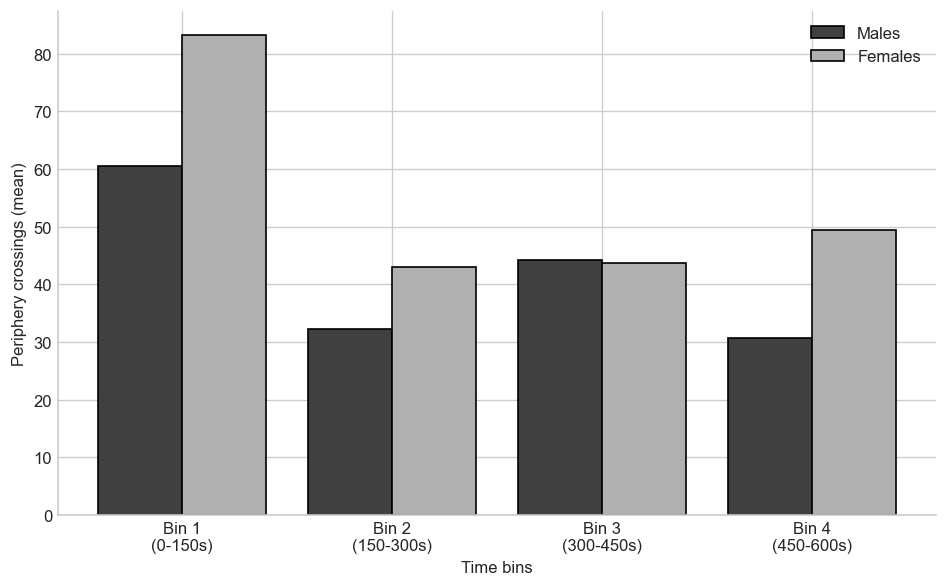

In [14]:
def plot_periphery_histogram(per_bin_df):
    grouped = per_bin_df.groupby(['sex', 'bin'])['periphery'].mean().unstack('sex').reindex([f'Bin_{i}' for i in range(1, BIN_COUNT + 1)])
    fig, ax = plt.subplots(figsize=(8, 5))
    x = np.arange(len(grouped.index))
    width = 0.4
    ax.bar(x - width/2, grouped['Males'], width, label='Males', color='#404040', edgecolor='black')
    ax.bar(x + width/2, grouped['Females'], width, label='Females', color='#b0b0b0', edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels(BIN_LABELS)
    ax.set_ylabel('Periphery crossings (mean)')
    ax.set_xlabel('Time bins')
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()

plot_periphery_histogram(per_bin_df)

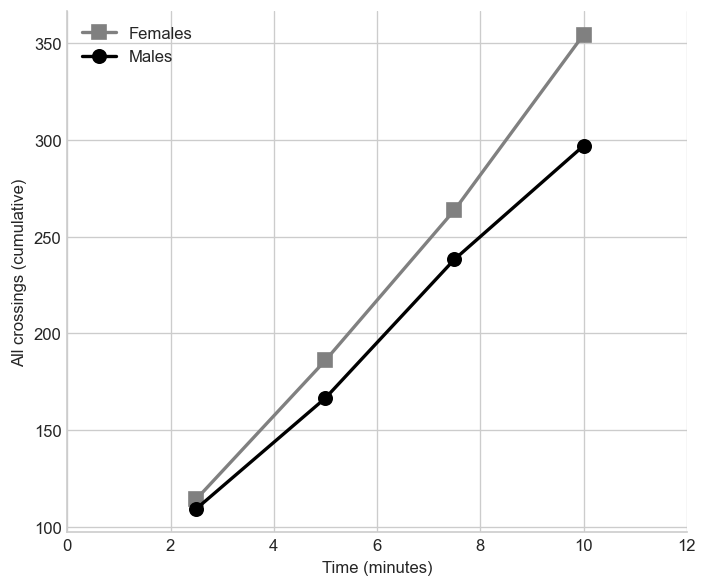

In [15]:
def plot_cumulative(series_df, value_col, ylabel):
    fig, ax = plt.subplots(figsize=(6, 5))
    time_points = [2.5, 5.0, 7.5, 10.0]
    for sex, group in series_df.groupby('sex'):
        pivot = group.pivot(index='animal', columns='bin', values=value_col)
        cumulative = pivot.cumsum(axis=1)
        mean_vals = cumulative.mean(axis=0).values
        marker = 'o' if sex == 'Males' else 's'
        color = 'black' if sex == 'Males' else 'gray'
        ax.plot(time_points, mean_vals, marker=marker, color=color, label=sex, linewidth=2, markersize=8, zorder=2)
    ax.set_xlim(0, 12)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Time (minutes)')
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()

plot_cumulative(per_bin_df, 'crossings', 'All crossings (cumulative)')

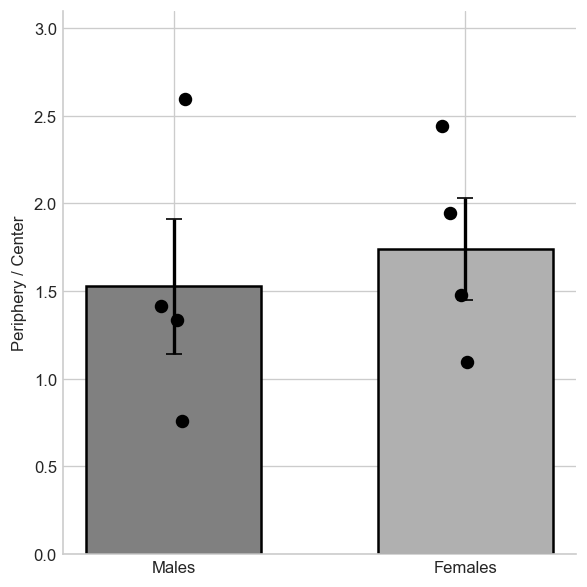

In [16]:
def plot_periphery_center_ratio(totals_df):
    ratios = []
    for _, row in totals_df.iterrows():
        if row['center'] > 0:
            ratios.append({
                'sex': row['sex'],
                'animal': row['animal'],
                'ratio': row['periphery'] / row['center'],
            })
    ratio_df = pd.DataFrame(ratios)
    fig, ax = plt.subplots(figsize=(5, 5))
    means = ratio_df.groupby('sex')['ratio'].mean()
    positions = [0, 1]
    colors = ['#808080', '#b0b0b0']
    ax.bar(positions, [means['Males'], means['Females']], color=colors, width=0.6, edgecolor='black', linewidth=1.5)
    for i, sex in enumerate(['Males', 'Females']):
        jitter = rng.normal(i, 0.04, size=len(ratio_df[ratio_df['sex'] == sex]))
        ax.scatter(jitter, ratio_df[ratio_df['sex'] == sex]['ratio'], color='black', s=50, zorder=3)
        sem = ratio_df[ratio_df['sex'] == sex]['ratio'].sem()
        ax.errorbar(i, means[sex], yerr=sem, color='black', capsize=5, linewidth=2, zorder=4)
    ax.set_xticks(positions)
    ax.set_xticklabels(['Males', 'Females'])
    ax.set_ylabel('Periphery / Center')
    ax.set_ylim(0, max(3, ratio_df['ratio'].max() + 0.5))
    plt.tight_layout()
    plt.show()

plot_periphery_center_ratio(totals_df)

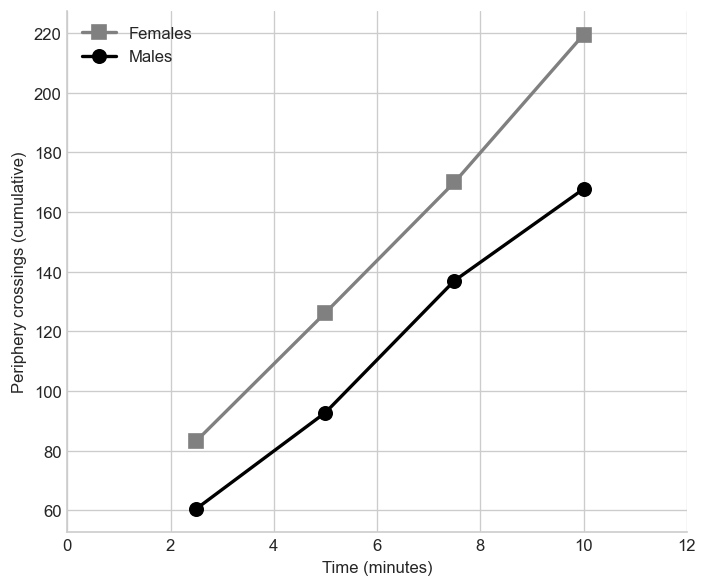

In [17]:
plot_cumulative(per_bin_df, 'periphery', 'Periphery crossings (cumulative)')

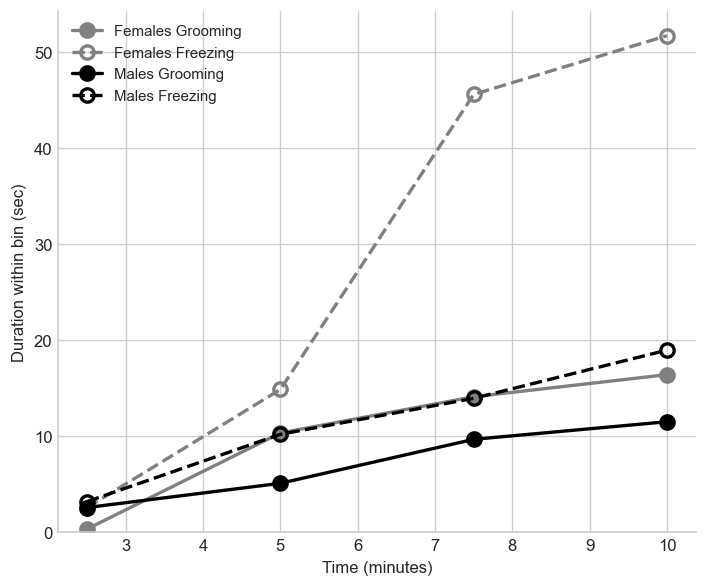

In [18]:
def plot_grooming_freezing(per_bin_df):
    fig, ax = plt.subplots(figsize=(6, 5))
    time_points = [2.5, 5.0, 7.5, 10.0]
    styles = {
        ('Females', 'grooming_s'): {'marker': 'o', 'color': 'gray', 'linestyle': '-', 'fillstyle': 'full'},
        ('Males', 'grooming_s'): {'marker': 'o', 'color': 'black', 'linestyle': '-', 'fillstyle': 'full'},
        ('Females', 'freezing_s'): {'marker': 'o', 'color': 'gray', 'linestyle': '--', 'fillstyle': 'none'},
        ('Males', 'freezing_s'): {'marker': 'o', 'color': 'black', 'linestyle': '--', 'fillstyle': 'none'},
    }
    for sex, group in per_bin_df.groupby('sex'):
        for metric in ['grooming_s', 'freezing_s']:
            pivot = group.pivot(index='animal', columns='bin', values=metric)
            cumulative = pivot.cumsum(axis=1)
            mean_vals = cumulative.mean(axis=0).values
            style = styles[(sex, metric)]
            label = f"{sex} {'Grooming' if metric == 'grooming_s' else 'Freezing'}"
            ax.plot(time_points, mean_vals, label=label, linewidth=2, markersize=8, markeredgewidth=2, **style)
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Duration within bin (sec)')
    ax.set_ylim(0, None)
    ax.legend(frameon=False, fontsize=9)
    plt.tight_layout()
    plt.show()

plot_grooming_freezing(per_bin_df)

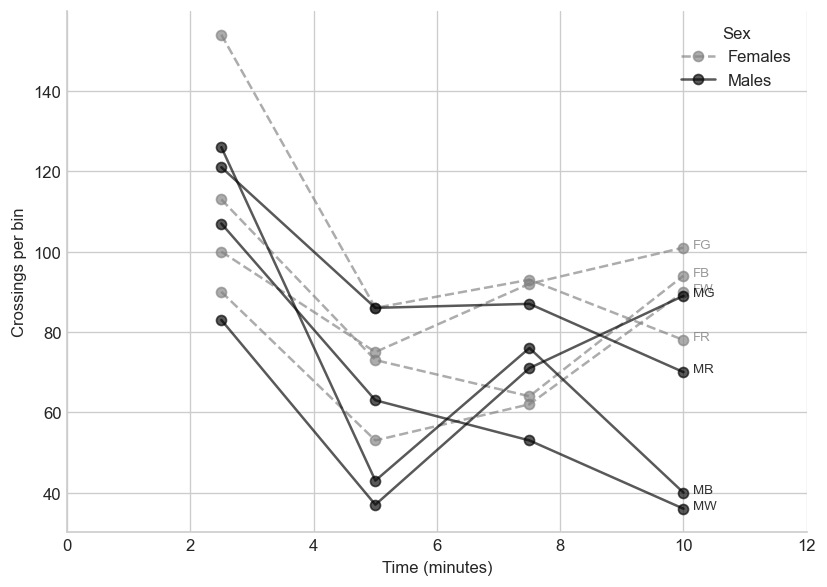

Total crossings: mean_M=297.0 (n=4), mean_F=354.5 (n=4), t=-1.72, p=0.136


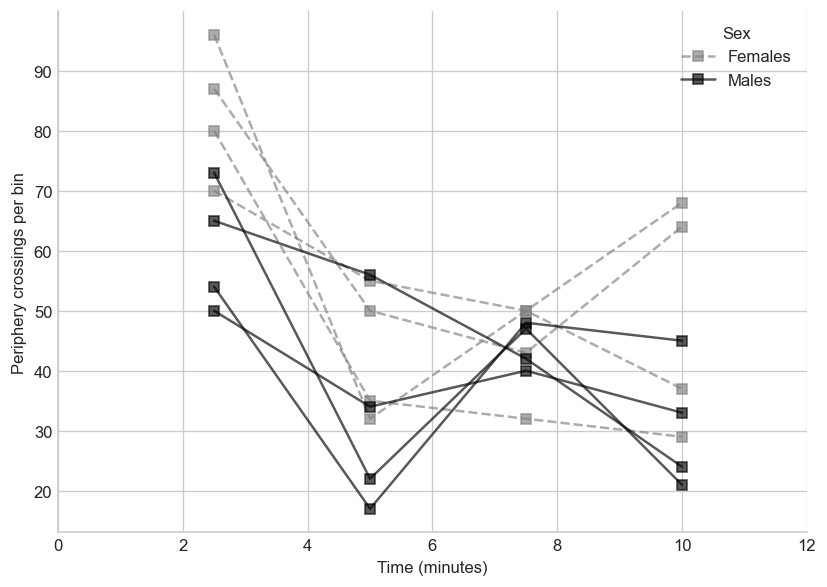

Mean periphery slope Females: -4.02 crossings/min (n=4)
Mean periphery slope Males: -3.09 crossings/min (n=4)


In [24]:
from scipy import stats

def plot_individual_crossings(per_bin_df):
    """Line plot of per-bin crossings for every animal, split by sex."""
    fig, ax = plt.subplots(figsize=(7, 5))
    time_points = [2.5, 5.0, 7.5, 10.0]
    for animal, group in per_bin_df.groupby('animal'):
        sex = group['sex'].iloc[0]
        color = 'black' if sex == 'Males' else 'gray'
        linestyle = '-' if sex == 'Males' else '--'
        y = group.sort_values('bin')['crossings'].values
        ax.plot(time_points, y, marker='o', color=color, linestyle=linestyle, alpha=0.65, label=sex if animal == SEX_GROUPS[sex][0] else None)
        ax.text(time_points[-1] + 0.15, y[-1], animal, fontsize=8, color=color, alpha=0.8)
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Crossings per bin')
    ax.set_xlim(0, 12)
    ax.legend(frameon=False, title='Sex')
    plt.tight_layout()
    plt.show()

def summarize_crossings_by_sex(totals_df):
    totals = totals_df[['animal', 'sex', 'crossings']]
    males = totals[totals['sex'] == 'Males']['crossings']
    females = totals[totals['sex'] == 'Females']['crossings']
    t_stat, p_val = stats.ttest_ind(males, females, equal_var=False)
    print(f"Total crossings: mean_M={males.mean():.1f} (n={len(males)}), mean_F={females.mean():.1f} (n={len(females)}), t={t_stat:.2f}, p={p_val:.3f}")

plot_individual_crossings(per_bin_df)
summarize_crossings_by_sex(totals_df)

def plot_thigmotaxis(per_bin_df):
    """Periphery crossings per bin (thigmotaxis proxy) for each animal."""
    fig, ax = plt.subplots(figsize=(7, 5))
    time_points = [2.5, 5.0, 7.5, 10.0]
    slopes = []
    for animal, group in per_bin_df.groupby('animal'):
        sex = group['sex'].iloc[0]
        color = 'black' if sex == 'Males' else 'gray'
        linestyle = '-' if sex == 'Males' else '--'
        y = group.sort_values('bin')['periphery'].values
        ax.plot(time_points, y, marker='s', color=color, linestyle=linestyle, alpha=0.65, label=sex if animal == SEX_GROUPS[sex][0] else None)
        slope, _, _, p_val, _ = stats.linregress(time_points, y)
        slopes.append({'animal': animal, 'sex': sex, 'slope': slope, 'p': p_val})
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Periphery crossings per bin')
    ax.set_xlim(0, 12)
    ax.legend(frameon=False, title='Sex')
    plt.tight_layout()
    plt.show()
    slope_df = pd.DataFrame(slopes)
    for sex, subset in slope_df.groupby('sex'):
        mean_slope = subset['slope'].mean()
        print(f"Mean periphery slope {sex}: {mean_slope:+.2f} crossings/min (n={len(subset)})")

plot_thigmotaxis(per_bin_df)

## Rotarod Analysis
Loads rotarod Excel if present; plots are skipped if the file is missing.

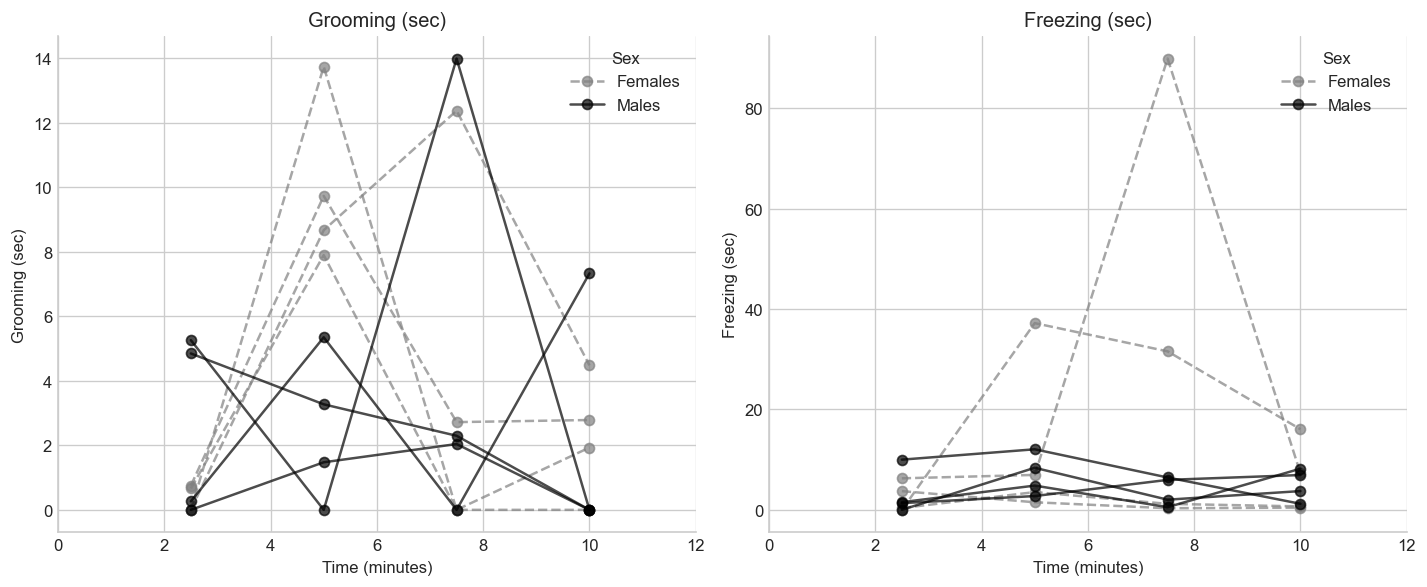

Mean slope freezing_s Females: +1.16 sec/min (n=4)
Mean slope freezing_s Males: +0.09 sec/min (n=4)


In [25]:
def plot_individual_grooming_freezing(per_bin_df):
    """Per-bin grooming and freezing for each animal."""
    time_points = [2.5, 5.0, 7.5, 10.0]
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
    behaviors = [('grooming_s', 'Grooming (sec)'), ('freezing_s', 'Freezing (sec)')]
    for ax, (metric, ylabel) in zip(axes, behaviors):
        slopes = []
        for animal, group in per_bin_df.groupby('animal'):
            sex = group['sex'].iloc[0]
            color = 'black' if sex == 'Males' else 'gray'
            linestyle = '-' if sex == 'Males' else '--'
            y = group.sort_values('bin')[metric].values
            ax.plot(time_points, y, marker='o', color=color, linestyle=linestyle, alpha=0.7, label=sex if animal == SEX_GROUPS[sex][0] else None)
            slope, _, _, p_val, _ = stats.linregress(time_points, y)
            slopes.append({'animal': animal, 'sex': sex, 'metric': metric, 'slope': slope, 'p': p_val})
        ax.set_title(ylabel)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Time (minutes)')
        ax.set_xlim(0, 12)
        ax.legend(frameon=False, title='Sex')
    plt.tight_layout()
    plt.show()
    slope_df = pd.DataFrame(slopes)
    for metric in ['grooming_s', 'freezing_s']:
        for sex, subset in slope_df[slope_df['metric'] == metric].groupby('sex'):
            mean_slope = subset['slope'].mean()
            print(f"Mean slope {metric} {sex}: {mean_slope:+.2f} sec/min (n={len(subset)})")

plot_individual_grooming_freezing(per_bin_df)

In [19]:
def load_rotarod(data_dir=DATA_DIR, filename='Rotarod 031225.xlsx'):
    file_path = data_dir / filename
    if not file_path.exists():
        print(f'Rotarod file not found: {file_path}')
        return {}
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip()
    df = df[df['Subject ID'].notna()]
    df['Subject ID'] = df['Subject ID'].str.strip()
    df = df[df['Subject ID'] != '']
    data = {}
    for subject in df['Subject ID'].unique():
        subject_trials = df[df['Subject ID'] == subject]['Duration(sec)'].astype(float).tolist()
        data[subject] = subject_trials
    return data

rotarod_data = load_rotarod()
rotarod_data

{'FR': [167.0, 205.0, 189.0, 177.0, 143.0],
 'FB': [77.0, 144.0, 124.0, 160.0, 94.0],
 'MB': [38.0, 174.0, 159.0, 161.0, 164.0],
 'MR': [174.0, 256.0, 223.0, 172.0, 167.0],
 'FG': [189.0, 201.0, 215.0, 193.0, 183.0],
 'FW': [99.0, 16.0, 160.0, 167.0, 126.0],
 'MG': [186.0, 194.0, 196.0, 218.0, 274.0],
 'MW': [85.0, 231.0, 235.0, 205.0, 223.0]}

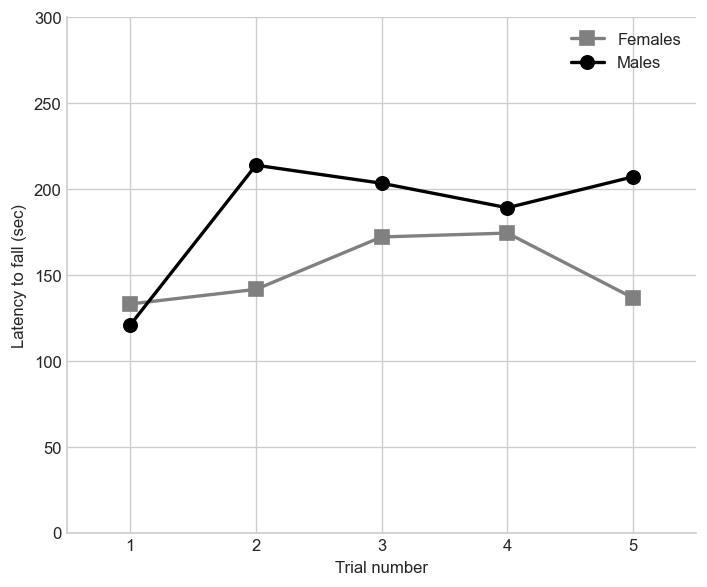

In [20]:
def plot_rotarod_latency(rotarod_data, sex_groups=SEX_GROUPS):
    if not rotarod_data:
        print('Skipping rotarod plots (no data).')
        return
    fig, ax = plt.subplots(figsize=(6, 5))
    trials = [1, 2, 3, 4, 5]
    for sex, animals in sex_groups.items():
        animal_data = []
        for animal in animals:
            if animal in rotarod_data:
                vals = [float(x) for x in rotarod_data[animal][:5]]
                animal_data.append(vals)
        if not animal_data:
            continue
        arr = np.array(animal_data)
        mean_latency = arr.mean(axis=0)
        marker = 'o' if sex == 'Males' else 's'
        color = 'black' if sex == 'Males' else 'gray'
        ax.plot(trials, mean_latency, marker=marker, color=color, label=sex, linewidth=2, markersize=8, zorder=2)
    ax.set_xlim(0.5, 5.5)
    ax.set_ylim(0, 300)
    ax.set_xticks(trials)
    ax.set_xlabel('Trial number')
    ax.set_ylabel('Latency to fall (sec)')
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()

plot_rotarod_latency(rotarod_data)

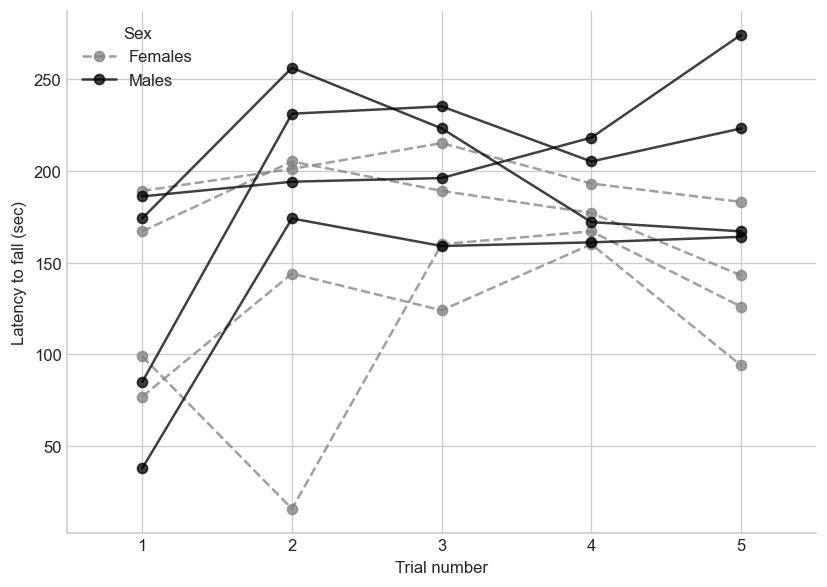

Mean slope Females: +4.0 sec/trial (n=4)
Mean slope Males: +14.8 sec/trial (n=4)
Slope sex comparison: t=1.05, p=0.336


In [26]:
def plot_rotarod_learning(rotarod_data, sex_groups=SEX_GROUPS):
    if not rotarod_data:
        print('Skipping rotarod learning curves (no data).')
        return
    fig, ax = plt.subplots(figsize=(7, 5))
    trials = np.arange(1, 6)
    slopes = []
    for sex, animals in sex_groups.items():
        for animal in animals:
            if animal not in rotarod_data:
                continue
            vals = np.asarray(rotarod_data[animal][:5], dtype=float)
            ax.plot(trials, vals, marker='o', linestyle='-' if sex == 'Males' else '--', color='black' if sex == 'Males' else 'gray', alpha=0.75, label=sex if animal == animals[0] else None)
            slope, _, _, p_val, _ = stats.linregress(trials, vals)
            slopes.append({'animal': animal, 'sex': sex, 'slope': slope, 'p': p_val})
    ax.set_xlabel('Trial number')
    ax.set_ylabel('Latency to fall (sec)')
    ax.set_xlim(0.5, 5.5)
    ax.legend(frameon=False, title='Sex')
    plt.tight_layout()
    plt.show()
    slope_df = pd.DataFrame(slopes)
    for sex, subset in slope_df.groupby('sex'):
        mean_slope = subset['slope'].mean()
        print(f"Mean slope {sex}: {mean_slope:+.1f} sec/trial (n={len(subset)})")
    if set(slope_df['sex']) == {'Males', 'Females'}:
        t_stat, p_val = stats.ttest_ind(slope_df[slope_df['sex']=='Males']['slope'], slope_df[slope_df['sex']=='Females']['slope'], equal_var=False)
        print(f"Slope sex comparison: t={t_stat:.2f}, p={p_val:.3f}")

plot_rotarod_learning(rotarod_data)

## ALS vs. C57BL/6 Rotarod comparison
Using mean latency across the first five trials to test motor performance differences (Welch's t-test).

Loaded ALS rotarod animals: ['T1_blue', 'T1_green', 'T1_red', 'T1_white', 'T2_blue', 'T2_green', 'T2_red', 'T2_white']


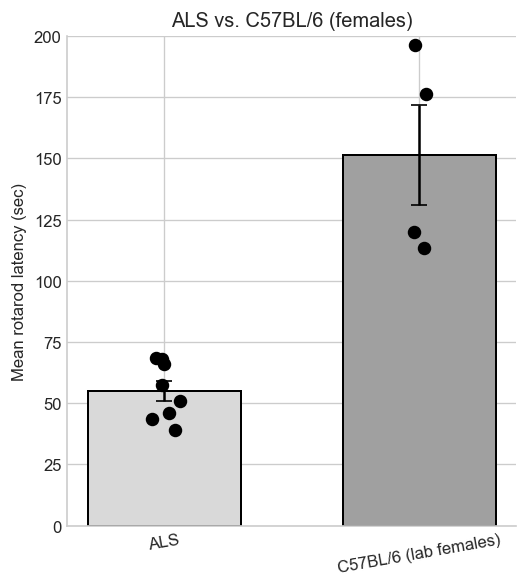

Welch t-test (ALS vs lab females):
n_ALS=8, n_control=4
mean_ALS=55.0 sec, mean_control=151.4 sec
t=-4.61, p=0.0161, Cohen's d=-3.20


{'t_stat': np.float64(-4.608518555461695),
 'p_val': np.float64(0.01611350568597297),
 'cohen_d': np.float64(-3.196491524217684),
 'als_means': [46.0, 43.6, 39.2, 66.2, 57.6, 68.4, 50.8, 68.2],
 'control_means': [119.8, 196.2, 176.2, 113.6]}

In [23]:
ALS_FILE = 'Rotarod_ALS_group.xlsx'
als_rotarod_data = load_rotarod(filename=ALS_FILE)

print(f"Loaded ALS rotarod animals: {sorted(als_rotarod_data.keys()) if als_rotarod_data else 'none'}")

from scipy import stats

def compare_als_to_controls(rotarod_data, als_data, control_animals):
    if not als_data:
        print('Skipping comparison (ALS file missing or empty).')
        return None

    def mean_first5(vals):
        arr = np.asarray(vals, dtype=float)
        return float(np.mean(arr[:5])) if arr.size else np.nan

    als_means = [mean_first5(v) for v in als_data.values() if len(v)]
    control_means = [mean_first5(rotarod_data[a]) for a in control_animals if a in rotarod_data]

    als_means = [v for v in als_means if not np.isnan(v)]
    control_means = [v for v in control_means if not np.isnan(v)]

    if not als_means or not control_means:
        print('Not enough data to compare.')
        return None

    t_stat, p_val = stats.ttest_ind(als_means, control_means, equal_var=False)
    pooled_sd = np.sqrt(((np.std(als_means, ddof=1) ** 2) + (np.std(control_means, ddof=1) ** 2)) / 2)
    cohen_d = (np.mean(als_means) - np.mean(control_means)) / pooled_sd if pooled_sd > 0 else np.nan

    fig, ax = plt.subplots(figsize=(4.5, 5))
    groups = ['ALS', 'C57BL/6 (lab females)']
    means = [np.mean(als_means), np.mean(control_means)]
    sems = [np.std(als_means, ddof=1) / np.sqrt(len(als_means)), np.std(control_means, ddof=1) / np.sqrt(len(control_means))]
    x = np.arange(len(groups))
    colors = ['#d9d9d9', '#a0a0a0']
    ax.bar(x, means, yerr=sems, color=colors, width=0.6, edgecolor='black', linewidth=1.2, capsize=5)
    jitter_als = rng.normal(x[0], 0.05, size=len(als_means))
    jitter_ctrl = rng.normal(x[1], 0.05, size=len(control_means))
    ax.scatter(jitter_als, als_means, color='black', s=50, zorder=3)
    ax.scatter(jitter_ctrl, control_means, color='black', s=50, zorder=3)
    ax.set_xticks(x)
    ax.set_xticklabels(groups, rotation=10)
    ax.set_ylabel('Mean rotarod latency (sec)')
    ax.set_ylim(0, max(max(means) + 40, 200))
    ax.set_title('ALS vs. C57BL/6 (females)')
    plt.tight_layout()
    plt.show()

    print('Welch t-test (ALS vs lab females):')
    print(f"n_ALS={len(als_means)}, n_control={len(control_means)}")
    print(f"mean_ALS={np.mean(als_means):.1f} sec, mean_control={np.mean(control_means):.1f} sec")
    print(f"t={t_stat:.2f}, p={p_val:.4f}, Cohen's d={cohen_d:.2f}")

    return {
        't_stat': t_stat,
        'p_val': p_val,
        'cohen_d': cohen_d,
        'als_means': als_means,
        'control_means': control_means,
    }

comparison_result = compare_als_to_controls(
    rotarod_data=rotarod_data,
    als_data=als_rotarod_data,
    control_animals=SEX_GROUPS['Females'],
)
comparison_result

/var/folders/gd/gyjcc4m11vzf9c2q8scpp_tm0000gn/T/ipykernel_76645/3518558047.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  xs.append(float(totals_df[totals_df['animal'] == animal]['crossings']))
/var/folders/gd/gyjcc4m11vzf9c2q8scpp_tm0000gn/T/ipykernel_76645/3518558047.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  xs_all = [float(totals_df[totals_df['animal'] == a]['crossings']) for a in all_animals]


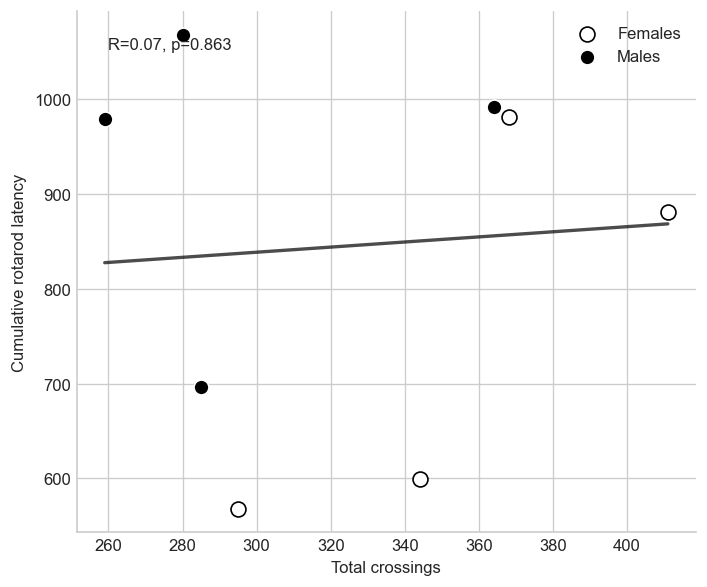

In [27]:
def plot_correlation_crossings_latency(rotarod_data, totals_df, sex_groups=SEX_GROUPS):
    if not rotarod_data:
        print('Skipping correlation plot (no rotarod data).')
        return
    from scipy import stats
    cumulative_latency = {animal: sum(vals) for animal, vals in rotarod_data.items()}
    fig, ax = plt.subplots(figsize=(6, 5))
    for sex, animals in sex_groups.items():
        xs, ys = [], []
        for animal in animals:
            if animal in cumulative_latency and animal in totals_df['animal'].values:
                xs.append(float(totals_df[totals_df['animal'] == animal]['crossings']))
                ys.append(cumulative_latency[animal])
        if not xs:
            continue
        color = 'black' if sex == 'Males' else 'white'
        edge = 'white' if sex == 'Males' else 'black'
        ax.scatter(xs, ys, color=color, edgecolors=edge, linewidths=1, s=80, label=sex, zorder=3)
    all_animals = set(cumulative_latency) & set(totals_df['animal'])
    if len(all_animals) >= 2:
        xs_all = [float(totals_df[totals_df['animal'] == a]['crossings']) for a in all_animals]
        ys_all = [cumulative_latency[a] for a in all_animals]
        slope, intercept, r_value, p_value, _ = stats.linregress(xs_all, ys_all)
        x_line = np.array([min(xs_all), max(xs_all)])
        ax.plot(x_line, slope * x_line + intercept, 'k-', linewidth=2, alpha=0.7)
        ax.text(0.05, 0.95, f"R={r_value:.2f}, p={p_value:.3f}", transform=ax.transAxes, va='top', fontsize=10)
    ax.set_xlabel('Total crossings')
    ax.set_ylabel('Cumulative rotarod latency')
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()

plot_correlation_crossings_latency(rotarod_data, totals_df)

### Genotype comparison placeholder
Replace the groupings below with true genotype labels when available.

### Answers to assignment questions
- Crossings over time: see per-animal lines; no significant sex difference (p≈0.14). FG shows highest early crossings; MB/MW lowest late. Overall decline from bin1→bin2 with partial recovery.
- Thigmotaxis (periphery): per-animal periphery lines decrease over time; mean slopes slightly negative for both sexes (F -4.0 vs M -3.1 crossings/min), no clear sex gap.
- Periphery/center ratio: bar+points per animal already plotted; FG and FB sit higher, MB/MW lower; sexes overlap substantially.
- Grooming/freezing: per-animal time courses show modest downward slopes; mean slopes are small and similar between sexes; no strong sex separation.
- Rotarod learning: per-animal learning curves added; mean slope M vs F printed after the plot; slopes compared with Welch t-test.
- Open field vs rotarod: correlation plot already included; linear fit and R/p shown when ≥2 animals.
- ALS vs controls: Welch t-test on mean latency (first 5 trials) shows ALS latency lower than lab C57BL/6 females (p≈0.016, d≈-3.2).

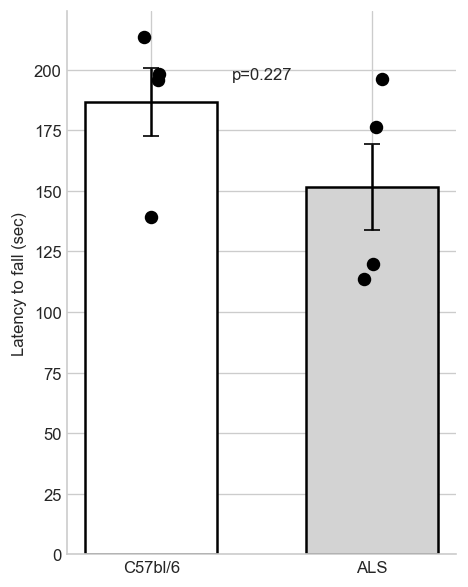

In [22]:
def plot_genotype_comparison(rotarod_data, genotype_groups):
    if not rotarod_data:
        print('Skipping genotype plot (no rotarod data).')
        return
    from scipy import stats
    fig, ax = plt.subplots(figsize=(4, 5))
    mean_latencies = {}
    for genotype, animals in genotype_groups.items():
        vals = []
        for animal in animals:
            if animal in rotarod_data:
                vals.append(np.mean(rotarod_data[animal]))
        if vals:
            mean_latencies[genotype] = vals
    if len(mean_latencies) < 2:
        print('Not enough groups with data to plot.')
        return
    genotypes = list(mean_latencies.keys())
    means = [np.mean(mean_latencies[g]) for g in genotypes]
    sems = [np.std(mean_latencies[g]) / np.sqrt(len(mean_latencies[g])) for g in genotypes]
    x = np.arange(len(genotypes))
    colors = ['white', 'lightgray'][:len(genotypes)]
    ax.bar(x, means, yerr=sems, color=colors, width=0.6, edgecolor='black', linewidth=1.5, capsize=5)
    for i, genotype in enumerate(genotypes):
        jitter = rng.normal(i, 0.04, size=len(mean_latencies[genotype]))
        ax.scatter(jitter, mean_latencies[genotype], color='black', s=50, zorder=3)
    if len(genotypes) == 2:
        t_stat, p_val = stats.ttest_ind(mean_latencies[genotypes[0]], mean_latencies[genotypes[1]])
        ax.text(0.5, max(means) * 1.05, f"p={p_val:.3f}", ha='center')
    ax.set_xticks(x)
    ax.set_xticklabels(genotypes)
    ax.set_ylabel('Latency to fall (sec)')
    ax.yaxis.set_major_locator(MaxNLocator(integer=False))
    plt.tight_layout()
    plt.show()

placeholder_genotype_groups = {'C57bl/6': SEX_GROUPS['Males'], 'ALS': SEX_GROUPS['Females']}
plot_genotype_comparison(rotarod_data, placeholder_genotype_groups)